# Code definitions

In [1]:
import matplotlib.pyplot as plt
from flax import linen as nn
from flax.training import train_state
import jax.numpy as jnp
import jax
from jax import random
import optax

import numpy as np
from scipy import special

from google import colab
import os
from argparse import Namespace
from collections import defaultdict
from typing import Callable

from tensorflow_probability.substrates import jax as tfp
tfpd = tfp.distributions


jax.config.update("jax_enable_x64", True)

In [2]:
class MLP(nn.Module):
  """Used for neural encoder and decoder"""
  output_dims: int
  activation_fn: Callable

  @nn.compact
  def __call__(self, *x):
    x = jnp.concatenate(x, -1)
    x = nn.Dense(128, name="fc1")(x)
    x = self.activation_fn(x)
    x = nn.Dense(128, name="fc2")(x)
    x = self.activation_fn(x)
    x = nn.Dense(self.output_dims, name="fc3")(x)
    return x

In [3]:
def cross_entropy_loss(*, logits, labels):
  posterior = jax.nn.softmax(logits)
  labels_index = jax.nn.one_hot(labels, num_classes=cur_input_message_dims, dtype=bool)
  posterior_target = jnp.sum(posterior * labels_index, axis=-1)
  cross_entropy = - jnp.log(posterior_target) / jnp.log(2)
  return cross_entropy

In [4]:
class DirtyPaperCodingModel(nn.Module):
  encoder_output_dims: int
  input_message_dims: int

  def setup(self):
    self.encoder = MLP(self.encoder_output_dims, jnp.sin)
    self.decoder = MLP(self.input_message_dims, jnp.sin)
    # other option for nonlineary is nn.leaky_relu
    # can change it to leaky_relu for structured experiments
    # more can be found here: https://jax.readthedocs.io/en/latest/jax.nn.html

  def __call__(self, input_message, channel_state, channel_noise, seq):
    # input message is in the form of modulation points in this case

    # encoder with side information (channel state known by the encoder)
    x = self.encoder(input_message, channel_state)

    # channel output
    x_w_noise = x + channel_noise + channel_state # Y = X + S + N, Eq. (2) in the paper

    # decoder, carrying out a classification
    posterior = self.decoder(x_w_noise)

    # encoder output power
    power_x = jnp.mean(jnp.sum(jnp.square(x), axis = 1)) # (see Section II.B in the paper)
    result = dict(power_x = power_x)

    # cross enctropy loss
    cross_entropy = cross_entropy_loss(logits=posterior, labels=seq)
    cross_entropy = jnp.mean(cross_entropy)

    x_out = jnp.argmax(posterior, -1)  # estimated message

    accuracy = jnp.mean(x_out == seq)  # 1 - BER

    result.update(cross_entropy=cross_entropy, accuracy=accuracy)

    return result


In [5]:
# Sampling for different modulations and state models

def sample_dpc_bpsk(num_samples, var_channel_state, var_channel_noise, input_rng):
  # BPSK message
  dist_message = tfp.distributions.Categorical(probs=[0.5, 0.5], dtype=int)
  modulation_array = jnp.array([-1., 1.])
  seq = dist_message.sample(seed=input_rng, sample_shape=(num_samples))
  seq = jnp.array(seq)
  modulated = jnp.take(modulation_array, seq)
  modulated = jnp.expand_dims(jnp.array(modulated), axis=1)
  input_message = modulated

  # Gaussian state (S) and noise (N)
  dist_noise = tfp.distributions.Normal(loc=0., scale=[var_channel_state ** .5, var_channel_noise ** .5])
  noises = dist_noise.sample(seed=input_rng, sample_shape=(num_samples, 1))
  channel_state, channel_noise = noises[..., 0], noises[..., 1]

  return input_message, channel_state, channel_noise, seq


def sample_dpc_qpsk(num_samples, var_channel_state, var_channel_noise, input_rng):
  # QPSK message
  dist_message = tfp.distributions.Categorical(probs=[0.25, 0.25, 0.25, 0.25], dtype=int)
  modulation_array = jnp.array([ # QPSK
       [0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678],
       [-0.70710678,  0.70710678],
       [-0.70710678, -0.70710678]])
  seq = dist_message.sample(seed=input_rng, sample_shape=(num_samples))
  seq = jnp.array(seq)

  modulated = jnp.take(modulation_array, seq, axis=0)
  input_message = modulated

  # complex (2d) Gaussian state (S) and noise (N)
  dist_noise = tfp.distributions.Normal(loc=0., scale=[(var_channel_state/2) ** .5, (var_channel_noise/2) ** .5]) # because of complex noise, dividing variance by 2 now.
  noises = dist_noise.sample(seed=input_rng, sample_shape=(num_samples, 2)) # complex noise
  channel_state, channel_noise = noises[..., 0], noises[..., 1]

  return input_message, channel_state, channel_noise, seq

def sample_dpc_bpsk_structured(num_samples, var_channel_state, var_channel_noise, input_rng):
  # BPSK message
  message_rng, channel_state_rng = random.split(input_rng)
  modulation_array = jnp.array([-1., 1.]) # BPSK

  dist_message = tfp.distributions.Categorical(probs=[0.5, 0.5], dtype=int)
  seq = dist_message.sample(seed=message_rng, sample_shape=(num_samples))
  seq = jnp.array(seq)
  modulated = jnp.take(modulation_array, seq)

  modulated = jnp.expand_dims(modulated, axis=1)
  input_message = modulated

  # BPSK state (S)
  dist_channel_state = tfp.distributions.Categorical(probs=[0.5, 0.5], dtype=int)
  channel_state = dist_channel_state.sample(seed=channel_state_rng, sample_shape=(num_samples))
  channel_state = jnp.take(modulation_array, channel_state) * jnp.sqrt(var_channel_state)
  channel_state = jnp.expand_dims(channel_state, axis=1)

  # Gaussian noise (N)
  dist_noise = tfp.distributions.Normal(loc=0., scale=var_channel_noise ** .5)
  channel_noise = dist_noise.sample(seed=channel_state_rng, sample_shape=(num_samples, 1))


  return input_message, channel_state, channel_noise, seq

def sample_dpc_qpsk_structured(num_samples, var_channel_state, var_channel_noise, input_rng):
  # QPSK message
  message_rng, channel_state_rng = random.split(input_rng)
  modulation_array = jnp.array([ # QPSK
       [0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678],
       [-0.70710678,  0.70710678],
       [-0.70710678, -0.70710678]])

  dist_message = tfp.distributions.Categorical(probs=[0.25, 0.25, 0.25, 0.25], dtype=int)
  seq = dist_message.sample(seed=message_rng, sample_shape=(num_samples))
  seq = jnp.array(seq)

  modulated = jnp.take(modulation_array, seq, axis=0)
  input_message = modulated

  # QPSK state (S)
  dist_channel_state = tfp.distributions.Categorical(probs=[0.25, 0.25, 0.25, 0.25], dtype=int)
  channel_state = dist_channel_state.sample(seed=channel_state_rng, sample_shape=(num_samples))
  channel_state = jnp.take(modulation_array, channel_state, axis=0) * jnp.sqrt(var_channel_state)

  # complex Gaussian (2d) noise (N)
  dist_noise = tfp.distributions.Normal(loc=0., scale=(var_channel_noise/2) ** .5) # because of complex noise, dividing variance by 2 now.
  channel_noise = dist_noise.sample(seed=input_rng, sample_shape=(num_samples, 2)) # complex noise

  return input_message, channel_state, channel_noise, seq


def sample_inputs(num_samples, var_channel_state, var_channel_noise, input_rng):
  if modulation_type == "bpsk":
    return sample_dpc_bpsk(num_samples, var_channel_state, var_channel_noise, input_rng)
  elif modulation_type == "qpsk":
    return sample_dpc_qpsk(num_samples, var_channel_state, var_channel_noise, input_rng)
  elif modulation_type == "bpsk_structured":
    return sample_dpc_bpsk_structured(num_samples, var_channel_state, var_channel_noise, input_rng)
  elif modulation_type == "qpsk_structured":
    return sample_dpc_qpsk_structured(num_samples, var_channel_state, var_channel_noise, input_rng)
  assert False

In [6]:
@jax.jit
def train_step(state, data_rng, lmbda):
  input_message, channel_state, channel_noise, seq = sample_inputs(batch_size, var_channel_state, var_channel_noise, data_rng)
  def loss_fn(params):
    result = model().apply(
        {'params': params}, input_message=input_message,
        channel_state=channel_state, channel_noise=channel_noise, seq=seq)
    r = Namespace(**result)

    loss = r.power_x + lmbda * r.cross_entropy # see Eq. (10) in the paper

    result.update(lmbda=lmbda, loss=loss)
    return loss, result
  grads, aux = jax.grad(loss_fn, has_aux=True)(state.params)
  return state.apply_gradients(grads=grads), aux

In [7]:
@jax.jit
def eval_step(state, input_message, channel_state, channel_noise, seq, lmbda):
  result = model().apply(
        {'params': state.params}, input_message=input_message,
        channel_state=channel_state, channel_noise=channel_noise, seq=seq)
  r = Namespace(**result)

  loss = r.power_x + lmbda * r.cross_entropy # see Eq. (10) in the paper

  return dict(val_power_x=r.power_x, val_loss=loss,
              val_cross_entropy=r.cross_entropy, val_accuracy=r.accuracy)


In [8]:
def plot_history(history):
  _, axs = plt.subplots(1, 4, figsize=(25, 5))

  for k in ["power_x", "val_power_x"]:
    axs[0].plot(history[k])
  axs[0].legend(["train", "val"], loc="best")
  axs[0].grid()
  axs[0].set_title("avg. power")

  for k in ["cross_entropy", "val_cross_entropy"]:
    axs[1].plot(history[k])
  axs[1].legend(["train", "val"], loc="best")
  axs[1].grid()
  axs[1].set_title("cross_entropy")
  axs[1].set_yscale("log")

  for k in ["accuracy", "val_accuracy"]:
    axs[2].plot(history[k])
  axs[2].legend(["train", "val"], loc="best")
  axs[2].grid()
  axs[2].set_title("accuracy")
  axs[2].set_yscale("log")

  for k in ["loss", "val_loss"]:
    axs[3].plot(history[k])
  axs[3].legend(["train", "val"], loc="best")
  axs[3].grid()
  axs[3].set_title("loss")
  axs[3].set_yscale("log")


In [9]:
def ser_bounds(power_x, snr_range = [-4.0,  12.0]):
  # ser vs snr lower bounds for different modulation schemes for AWGN channel
  N_pts = 100
  snr_vals_db = np.linspace(snr_range[0], snr_range[1], N_pts)
  snr_vals = 10.0 ** (snr_vals_db / 10)

  if modulation_type == "bpsk" or modulation_type == "bpsk_structured":

    ser_lb = 0.5 - 0.5*special.erf(np.sqrt(snr_vals/2))
    ser_lb_db = np.log10(ser_lb)

  elif modulation_type == "qpsk" or modulation_type == "qpsk_structured":

    ser_lb = 2*(0.5 - 0.5*special.erf(np.sqrt(snr_vals/2)))
    ser_lb_db = np.log10(ser_lb)

  return ser_lb_db, snr_vals_db


def plot_bounds(power_x, var_channel_state,  snr_range = [-4.0, 12.0]):

  ser_lb_db, snr_vals_db = ser_bounds(power_x, snr_range)

  plt.plot(snr_vals_db, ser_lb_db, label = "Lower bound (AWGN)")

# ser vs snr performance of Tomlinson-Harashima precoder based schemes
th_bpsk_ser = np.array([-0.302, -0.307, -0.313, -0.323, -0.337, -0.356, -0.382, -0.414, -0.452, -0.498, -0.552, -0.613, -0.684, -0.766, -0.856, -0.961, -1.083, -1.218, -1.372, -1.558, -1.76, -2.01, -2.289, -2.6, -2.971, -3.427, -3.899, -4.521, -5.142])
th_bpsk_snr = np.array([-5,	-4.31,	-3.62,	-2.931,	-2.241,	-1.551,	-0.862, -0.172,	0.5172,	1.2068,	1.8965,	2.5862,	3.2758,	3.9655,	4.6551,	5.3448,	6.0344,	6.7241,	7.4137,	8.1034,	8.7931,	9.4827,	10.172,	10.862,	11.551,	12.241,	12.931,	13.62,	14.31])


th_qpsk_ser = np.array([-0.1268, -0.1292, -0.1334, -0.1404, -0.1498, -0.1637, -0.1823, -0.2058, -0.2365, -0.2722, -0.3165, -0.3700, -0.4313, -0.5038, -0.588, -0.6856, -0.7994, -0.9312, -1.0846, -1.2634, -1.4699, -1.7053, -1.9842, -2.3171, -2.6868, -3.1135, -3.6091, -4.2534, -5.664])
th_qpsk_snr = np.array([-5,	-4.31,	-3.62,	-2.931,	-2.241,	-1.551,	-0.862, -0.172,	0.5172,	1.2068,	1.8965,	2.5862,	3.2758,	3.9655,	4.6551,	5.3448,	6.0344,	6.7241,	7.4137,	8.1034,	8.7931,	9.4827,	10.172,	10.862,	11.551,	12.241,	12.931,	13.62,	14.31])

# Experiments


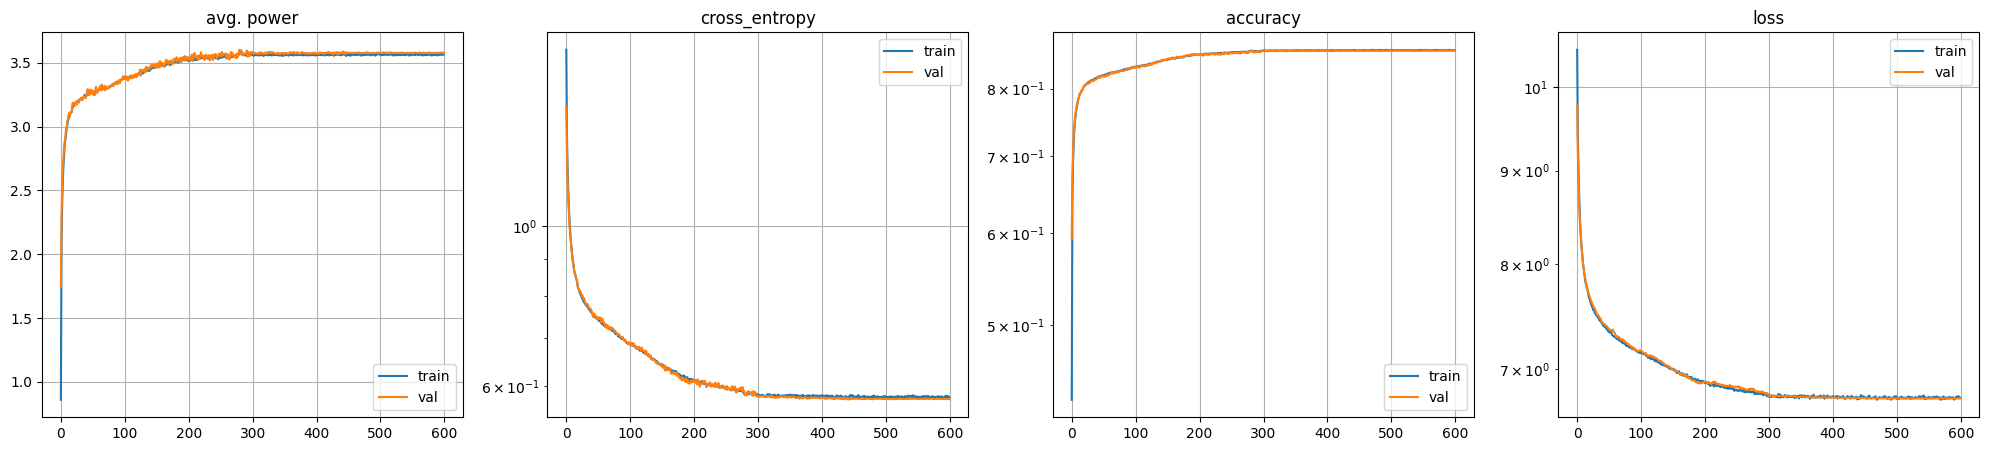

epoch  599
train      (avg.) power  3.565, cross-entropy  0.5791, accuracy  0.8629, loss  6.7506
validation (avg.) power  3.578, cross-entropy  0.5757, accuracy  0.8625, loss  6.7447


In [10]:
lmbda = 5.5 # power - ser trade off parameter
var_channel_state, var_channel_noise = 30.0, 1.0 # channel state and noise variance
# modulation type options: bpsk, qpsk, bpsk_structured, qpsk_structured
modulation_type = "qpsk"

if modulation_type == "bpsk" or modulation_type == "bpsk_structured":
  entropy_message = 1. # equally likely symbols
  cur_input_message_dims = 2
  encoder_output_dims = 1
elif modulation_type == "qpsk" or modulation_type == "qpsk_structured":
  entropy_message = 2. # equally likely symbols
  cur_input_message_dims = 4
  encoder_output_dims = 2
else:
  assert False # not defined yet.

print('lmbda is', lmbda)
print('modulation type is', modulation_type)
print('variance for channel state is', var_channel_state, 'and variance for channel noise is', var_channel_noise)

init_samples = 10
batch_size = 1024
num_epochs = 150 * 4
steps_per_epoch = 1000
validation_size = 60 * 1024
test_steps = 1024

total_steps = num_epochs * steps_per_epoch

lr_schedule = optax.piecewise_constant_schedule(
    init_value=1e-4,
    boundaries_and_scales={
        int(2/4 * total_steps): 1e-1,
        int(3/4 * total_steps): 1e-1,
    },
)

def model():
  return DirtyPaperCodingModel(input_message_dims=cur_input_message_dims, encoder_output_dims=encoder_output_dims)

seed, = np.frombuffer(os.getrandom(4), dtype=np.int32)
rng = random.PRNGKey(seed)

rng, init_rng, init_data_rng = random.split(rng, 3)
init_input_message, init_channel_state, init_channel_noise, init_seq = sample_inputs(
              init_samples, var_channel_state, var_channel_noise, init_data_rng)
state = train_state.TrainState.create(
    apply_fn=model().apply,
    params=model().init(init_rng,
                        input_message=init_input_message,
                        channel_state=init_channel_state,
                        channel_noise=init_channel_noise,
                        seq=init_seq
       )['params'],
    tx=optax.adam(lr_schedule),
)

rng, data_rng = random.split(rng)
validation_set = sample_inputs(validation_size, var_channel_state, var_channel_noise, data_rng)

history = defaultdict(lambda: np.full((num_epochs,), float("nan")))

# Training loop
for epoch in range(num_epochs):
  results = defaultdict(lambda: 0, lr=lr_schedule(state.step))

  for _ in range(steps_per_epoch):
    rng, data_rng = random.split(rng)
    state, result = train_step(
          state, data_rng=data_rng, lmbda=lmbda)
    for k in result:
      results[k] += result[k]
  for k in results:
    results[k] /= steps_per_epoch

  results.update(eval_step(state, *validation_set, lmbda=lmbda))

  for k in results:
    history[k][epoch] = results[k]

  colab.output.clear(wait=True)
  plot_history(history)
  plt.show()
  print(f"epoch {epoch:4}")
  print(f"train      (avg.) power {history['power_x'][epoch]:6.3f}, cross-entropy {history['cross_entropy'][epoch]:7.4f}, accuracy {history['accuracy'][epoch]:7.4f}, loss {history['loss'][epoch]:7.4f}")
  print(f"validation (avg.) power {history['val_power_x'][epoch]:6.3f}, cross-entropy {history['val_cross_entropy'][epoch]:7.4f}, accuracy {history['val_accuracy'][epoch]:7.4f}, loss {history['val_loss'][epoch]:7.4f}", flush=True)


In [11]:
# inference for matching train-test var_channel_state
metrics = defaultdict(lambda: 0)
for _ in range(test_steps):
  rng, data_rng = random.split(rng)
  result = eval_step(state, *sample_inputs(batch_size, var_channel_state, var_channel_noise, data_rng), lmbda=lmbda)
  for k in result:
    metrics[k] += result[k]
for k in metrics:
  metrics[k] /= test_steps
print(f"Test (avg.) power {metrics['val_power_x']:6.6f}, cross-entropy {metrics['val_cross_entropy']:7.6f}, accuracy {metrics['val_accuracy']:7.6f}, loss {metrics['val_loss']:6.6f}")


print(f"pgfplots: avg. power {metrics['val_power_x']:11.10f}, bit error rate  {1 - metrics['val_accuracy']:11.10f}, Capacity-LowerBound {entropy_message-metrics['val_cross_entropy']:11.10f}, for lmbda = {lmbda}")
print(f"[dB] pgfplots: avg. power {10*np.log10(metrics['val_power_x']/var_channel_noise):11.10f}, bit error rate  {np.log10(1 - metrics['val_accuracy']):11.10f}, Capacity-LowerBound {entropy_message-metrics['val_cross_entropy']:11.10f}, for lmbda = {lmbda}")

Test (avg.) power 3.561987, cross-entropy 0.578307, accuracy 0.863736, loss 6.742678
pgfplots: avg. power 3.5619869981, bit error rate  0.1362638474, Capacity-LowerBound 1.4216925185, for lmbda = 5.5
[dB] pgfplots: avg. power 5.5169232987, bit error rate  -0.8656193614, Capacity-LowerBound 1.4216925185, for lmbda = 5.5


# Plotting

[dB] pgfplots: avg. power 5.5169232987, bit error rate  -0.8656193614 for lmbda = 5.5


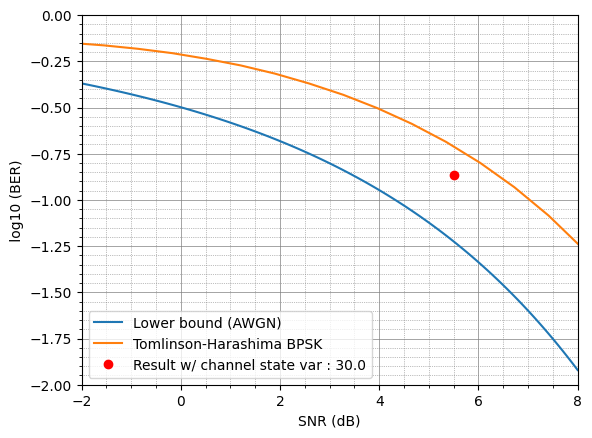

In [12]:
# Comparison with AWGN lower bound and THP

plot_bounds(metrics['val_power_x'], var_channel_state,  snr_range = [-2.0, 8.0])

if modulation_type == "bpsk" or modulation_type == "bpsk_structured":
  plt.plot(th_bpsk_snr, th_bpsk_ser, label="Tomlinson-Harashima BPSK")
elif modulation_type == "qpsk" or modulation_type == "qpsk_structured":
  plt.plot(th_bpsk_snr, th_qpsk_ser, label="Tomlinson-Harashima BPSK")


plt.plot(10*np.log10(metrics['val_power_x']/var_channel_noise) , np.log10(1 - metrics['val_accuracy']), 'ro', label=f"Result w/ channel state var : {var_channel_state}")
print(f"[dB] pgfplots: avg. power {10*np.log10(metrics['val_power_x']/var_channel_noise):11.10f}, bit error rate  {np.log10(1 - metrics['val_accuracy']):11.10f} for lmbda = {lmbda}")

plt.xlabel("SNR (dB)")
plt.ylabel(" log10 (BER) ")

plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.ylim(-2.0, 0)
plt.xlim(-2.0,8.0)

plt.legend()
plt.show()

## Encoder/Decoder Behaviour

In [13]:
@jax.jit
def encoder_behavior(state, input_message, channel_state):
  return model().apply(
      {'params': state.params}, method = lambda m: m.encoder(input_message, channel_state))

@jax.jit
def decoder_behavior(state, input_w_noise):
  return model().apply(
      {'params': state.params}, method = lambda m: m.decoder(input_w_noise))


In [14]:
def plot_THP_encoder_bpsk(channel_state, metrics):
  # BPSK encoder output vs channel state for THP, see Eq. (3) in the paper
  avg_power = metrics['val_power_x']
  modulo_width = np.sqrt(avg_power * 12)

  th_encoder_output = np.mod(-channel_state + modulo_width/2, modulo_width) - modulo_width/2;

  plt.plot(channel_state, th_encoder_output, '-k', label=f"TH Encoder w/ same avg. power")

def plot_encoding_bpsk(state, input_symbols, channel_state_lim = 15.):
  # Plot and compare encoder output vs channel state for learned model and THP
  plt.figure(figsize=(10, 6))
  channel_state = np.linspace(-channel_state_lim, channel_state_lim, 700)[:, None]

  for input_symbol in input_symbols:
    input_message = np.full(channel_state.shape, input_symbol)
    encoder_output = encoder_behavior(state, input_message, channel_state)
    plt.plot(channel_state, encoder_output, marker='o', linestyle='-', label=f"Input Symbol: {input_symbol}")

  plot_THP_encoder_bpsk(channel_state, metrics)

  plt.xlabel("Channel State")
  plt.ylabel("Encoder Output")
  plt.title("Encoder Output for Different Input Symbols and Channel States")

  # More precise grid
  plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
  plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
  plt.minorticks_on()

  #plt.ylim(-.5, .5) # change the boundaries accordingly
  plt.legend()
  plt.show()

def plot_decoding_bpsk(state):
  # Decision bounds for bpsk modulation
  num_samples = 100 * 2
  plt.figure(figsize=(10, 2))
  channel_output = np.linspace(-15, 15, num_samples)[:, None]

  decoded_output = decoder_behavior(state, channel_output)
  estimated_message = jnp.argmax(decoded_output, -1)  # estimated message

  plt.plot(channel_output, estimated_message)

  plt.xlabel("Channel Output")
  plt.ylabel("[Hard] Decoder Output")
  plt.title("[Hard] Decoder Output for Different Input Symbols and Channel States")

  # More precise grid
  plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
  plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
  plt.minorticks_on()

  plt.legend()
  plt.show()

def plot_decoding_qpsk(state, channel_state_lim = 16):
    # Decision bounds for qpsk modulation
    channel_states = np.linspace(-channel_state_lim, channel_state_lim, 200)
    X, Y = np.meshgrid(channel_states, channel_states)
    channel_state = np.stack((X.flatten(), Y.flatten()), axis=-1)

    # Assuming decoder_behavior takes a 2D input (real and imaginary parts)
    decoded_output = decoder_behavior(state, channel_state)
    estimated_message = jnp.argmax(decoded_output, axis=-1)

    # Reshape the estimated message to match the meshgrid shape
    Z = estimated_message.reshape(X.shape)

    plt.figure(figsize=(8, 6))
    plt.imshow(Z, extent=[channel_states.min(), channel_states.max(), channel_states.min(), channel_states.max()], origin='lower', cmap='viridis', vmin=0, vmax=3) #Set vmin and vmax for 4 discrete classes
    plt.xlabel("Channel Output (Real)")
    plt.ylabel("Channel Output (Imaginary)")
    plt.title("Hard Decoder Decisions (QPSK)")
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    plt.minorticks_on()
    plt.show()

In [15]:
# Encoder Behavior
if modulation_type == "bpsk":
  plot_encoding_bpsk(state, input_symbols=[-1, 1]) # input symbols are BPSK ones

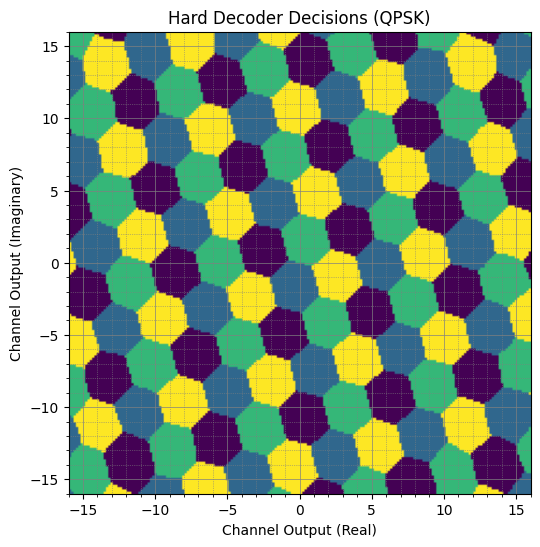

In [16]:
# Decoder bahvior
if modulation_type == "bpsk":
  plot_decoding_bpsk(state) # BPSK
elif modulation_type == "qpsk":
  plot_decoding_qpsk(state) # QPSK